In [1]:
from google.colab import files
uploaded = files.upload()

Saving DL_Assignment1_Dataset.zip to DL_Assignment1_Dataset.zip


In [2]:
import zipfile, io

with zipfile.ZipFile(io.BytesIO(uploaded['DL_Assignment1_Dataset.zip']), 'r') as zip_ref:
    zip_ref.extractall('DL_Assignment1_Dataset')

In [3]:
# Installing additional required packages
!pip install -q tensorflow==2.14.1 scikit-learn matplotlib tensorflow-addons efficientnet

# Printing GPU status
import tensorflow as tf
print("tf version:", tf.__version__)
gpuDevices = tf.config.list_physical_devices('GPU')
print("gpu devices found:", gpuDevices)

# Enabling mixed precision for faster training on supported GPUs
from tensorflow.keras import mixed_precision
try:
    mixed_precision.set_global_policy('mixed_float16')
    print("mixed precision is enabled")
except Exception as e:
    print("mixed precision could not be enabled:", e)

ERROR: Could not find a version that satisfies the requirement tensorflow==2.14.1 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.14.1
tf version: 2.19.0
gpu devices found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
mixed precision is enabled


In [8]:
# importing libraries and setting global variables
import os
import numpy as np
import pandas as pd
import random
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from scipy.stats import pearsonr
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

# global paths
rootFolder = "/content/DL_Assignment1_Dataset/Dataset/Dataset"
imageFolder = os.path.join(rootFolder, "images")
annotationFolder = os.path.join(rootFolder, "annotations")

# training parameters
imgHeight = 224
imgWidth = 224
batchSize = 32
numClasses = 8
randomSeed = 42
tf.random.set_seed(randomSeed)
np.random.seed(randomSeed)
random.seed(randomSeed)


In [12]:
# defining annotation loader for scalar .npy files (presenting filename parsing)
def loadAnnotations(annotationFolder):
    records = []
    for f in os.listdir(annotationFolder):
        if f.endswith(".npy"):
            filePath = os.path.join(annotationFolder, f)
            value = np.load(filePath, allow_pickle=True)

            # parsing filename: e.g., 4004_val.npy → id=4004, type=val
            base = f.replace(".npy", "")
            parts = base.split("_")
            faceId = parts[0]
            labelType = parts[1] if len(parts) > 1 else "unknown"

            records.append({
                "faceId": faceId,
                "labelType": labelType,
                "value": value,
                "sourceFile": f
            })

    return pd.DataFrame(records)

# running loader
annotationDf = loadAnnotations(annotationFolder)
print("head of annotation dataframe (presenting):")
print(annotationDf.head())


head of annotation dataframe (presenting):
  faceId labelType                                              value  \
0   4004       val                                          -0.595238   
1   3039       exp                                                  4   
2    698       aro                                          -0.293651   
3   2950       lnd  [43.65744966442953, 108.29974683544305, 42.454...   
4    899       val                                          -0.603175   

     sourceFile  
0  4004_val.npy  
1  3039_exp.npy  
2   698_aro.npy  
3  2950_lnd.npy  
4   899_val.npy  


In [19]:
import os, glob
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Fix annotation dataframe ---
def prepare_annotations(annotationDf):
    # extract numeric ID from sourceFile (e.g. 1001 from "1001_val.npy")
    annotationDf["faceId"] = annotationDf["sourceFile"].str.split("_").str[0]

    # pivot so each row = one image, columns = val/aro/exp
    wideAnn = annotationDf.pivot_table(
        index="faceId",
        columns="labelType",
        values="value",
        aggfunc="first"
    ).reset_index()

    # rename to consistent column names
    wideAnn = wideAnn.rename(columns={"val": "valence", "aro": "arousal", "exp": "expression"})

    return wideAnn

wideAnn = prepare_annotations(annotationDf)
print("Prepared annotation dataframe:")
print(wideAnn.head())

# --- Build dataframe mapping images to annotations ---
def buildImageDataframe(imageFolder, wideAnn):
    records = []
    for _, row in wideAnn.iterrows():
        faceId = str(row["faceId"])
        imgName = f"{faceId}.jpg"
        imgPath = os.path.join(imageFolder, imgName)

        if os.path.exists(imgPath):
            records.append({
                "imagePath": imgPath,
                "expression": int(row["expression"]) if not pd.isna(row["expression"]) else None,
                "valence": float(row["valence"]) if not pd.isna(row["valence"]) else None,
                "arousal": float(row["arousal"]) if not pd.isna(row["arousal"]) else None
            })

    return pd.DataFrame(records)

imageDf = buildImageDataframe(imageFolder, wideAnn)

print("total examples found:", len(imageDf))
print(imageDf.head())

# --- Split into train/val ---
if "expression" in imageDf.columns and imageDf["expression"].notna().nunique() > 1:
    trainDf, valDf = train_test_split(
        imageDf,
        test_size=0.15,
        random_state=randomSeed,
        stratify=imageDf["expression"]
    )
else:
    trainDf, valDf = train_test_split(
        imageDf,
        test_size=0.15,
        random_state=randomSeed
    )

trainDf = trainDf.reset_index(drop=True)
valDf = valDf.reset_index(drop=True)

print("train size:", len(trainDf), "val size:", len(valDf))

Prepared annotation dataframe:
labelType faceId     arousal expression  \
0              0  -0.0776398          0   
1              1    0.183895          0   
2             10    0.658149          7   
3            100    0.666667          3   
4           1001  0.00483933          0   

labelType                                                lnd    valence  
0          [-0.00666666666666534, 81.49801169590643, 2.81...  -0.176846  
1          [44.95157894736842, 103.7217391304348, 45.3726...  -0.367789  
2          [7.73316923076923, 95.77069016152717, 10.71753...  -0.648471  
3          [29.836800000000004, 69.58, 29.740307692307695...   0.150794  
4          [3.08131455399061, 119.5911111111111, 6.099530...  -0.135501  
total examples found: 3999
                                           imagePath  expression   valence  \
0  /content/DL_Assignment1_Dataset/Dataset/Datase...           0 -0.176846   
1  /content/DL_Assignment1_Dataset/Dataset/Datase...           0 -0.367789   
2  /c

In [21]:
# creating tf.data pipeline and augmentation
AUTOTUNE = tf.data.experimental.AUTOTUNE

def parseImage(examplePath, imgHeight=224, imgWidth=224):
    # loading and preprocessing image
    image = tf.io.read_file(examplePath)
    image = tf.image.decode_jpeg(image, channels=3)  # decode_jpeg is safer than decode_image
    image = tf.image.resize(image, [imgHeight, imgWidth])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# augmentation function
def augmentImage(image):
    # applying simple augmentations on the fly
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    # using TensorFlow rotation instead of tfa
    angle = tf.random.uniform([], -0.05, 0.05)  # radians
    image = tfa_rotate_fallback(image, angle)
    return image

def tfa_rotate_fallback(image, angle):
    # rotating with tf.raw_ops
    return tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

def makeDataset(df, batchSize=32, isTraining=True, shuffle=True):
    # creating dataset from dataframe
    paths = df['imagePath'].values
    expressions = tf.keras.utils.to_categorical(df['expression'].values, numClasses)
    valence = df['valence'].values.astype(np.float32)
    arousal = df['arousal'].values.astype(np.float32)
    labelsRegression = np.stack([valence, arousal], axis=1)

    ds = tf.data.Dataset.from_tensor_slices((paths, expressions, labelsRegression))
    if shuffle and isTraining:
        ds = ds.shuffle(buffer_size=len(df), seed=randomSeed)
    def _load(path, expr, reg):
        img = parseImage(path, imgHeight, imgWidth)
        if isTraining:
            img = augmentImage(img)
        return img, {'classOutput': expr, 'vaOutput': reg}
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batchSize).prefetch(AUTOTUNE)
    return ds

# constructing datasets
trainDataset = makeDataset(trainDf, batchSize=batchSize, isTraining=True, shuffle=True)
valDataset = makeDataset(valDf, batchSize=batchSize, isTraining=False, shuffle=False)


In [22]:
# building modular model factory
from tensorflow.keras.applications import ResNet50, EfficientNetB0, resnet50, efficientnet

def buildMultiTaskModel(backboneName='ResNet50', inputShape=(224,224,3), dropoutRate=0.4):
    # selecting backbone and constructing shared representation
    inputs = layers.Input(shape=inputShape)
    if backboneName.lower() == 'resnet50':
        # creating resnet50 backbone
        baseModel = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs, pooling='avg')
        baseOutput = baseModel.output
    elif backboneName.lower() == 'efficientnetb0':
        baseModel = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs, pooling='avg')
        baseOutput = baseModel.output
    else:
        raise ValueError("unsupported backbone: choose 'ResNet50' or 'EfficientNetB0'")

    # building classification head
    x = layers.Dropout(dropoutRate)(baseOutput)
    classDense = layers.Dense(256, activation='relu')(x)
    classOutput = layers.Dense(numClasses, activation='softmax', name='classOutput')(classDense)

    # building regression head (valence+arousal)
    y = layers.Dropout(dropoutRate)(baseOutput)
    regDense = layers.Dense(128, activation='relu')(y)
    # using linear activation for regression
    vaOutput = layers.Dense(2, activation='tanh', name='vaOutput')(regDense)  # tanh mapped to [-1,1]

    model = models.Model(inputs=inputs, outputs=[classOutput, vaOutput], name=f"multiTask_{backboneName}")
    return model

# example model creation
exampleModel = buildMultiTaskModel('ResNet50', inputShape=(imgHeight, imgWidth, 3))
exampleModel.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "multiTask_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,376,842 (92.99 MB)

 Trainable params: 24,323,722 (92.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [23]:
# compiling model with appropriate losses and metrics
def compileModel(model, learningRate=1e-4):
    # defining losses and weighting
    losses = {
        'classOutput': 'categorical_crossentropy',
        'vaOutput': 'mse'  # using mean squared error for valence & arousal
    }
    lossWeights = {'classOutput': 1.0, 'vaOutput': 1.0}

    # defining metrics for classification
    metrics = {
        'classOutput': ['accuracy'],
        'vaOutput': []
    }
    model.compile(optimizer=tf.keras.optimizers.Adam(learningRate),
                  loss=losses, loss_weights=lossWeights, metrics=metrics)
    return model

# example compile
exampleModel = compileModel(exampleModel, learningRate=1e-4)


In [25]:
# creating a reusable training function
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

def trainBaseline(backboneName, trainDataset, valDataset, epochs=20, outputDir='/content/models'):
    # preparing model and callbacks
    model = buildMultiTaskModel(backboneName, inputShape=(imgHeight, imgWidth, 3))
    model = compileModel(model, learningRate=1e-4)

    os.makedirs(outputDir, exist_ok=True)
    modelPath = os.path.join(outputDir, f"{model.name}.h5")

    callbacks = [
    ModelCheckpoint(modelPath, monitor='val_classOutput_accuracy', save_best_only=True, verbose=1, mode='max'),
    ReduceLROnPlateau(monitor='val_classOutput_accuracy', factor=0.5, patience=3, verbose=1, mode='max'),
    EarlyStopping(monitor='val_classOutput_accuracy', patience=6, restore_best_weights=True, verbose=1, mode='max')
    ]

    history = model.fit(trainDataset,
                        validation_data=valDataset,
                        epochs=epochs,
                        callbacks=callbacks)
    return model, history, modelPath

# training ResNet50 baseline
resnetModel, resnetHistory, resnetModelPath = trainBaseline('ResNet50', trainDataset, valDataset, epochs=12)

# training EfficientNetB0 baseline
effModel, effHistory, effModelPath = trainBaseline('EfficientNetB0', trainDataset, valDataset, epochs=12)


Epoch 1/12
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - classOutput_accuracy: 0.1650 - classOutput_loss: 2.2769 - loss: 2.8433 - vaOutput_loss: 0.5663
Epoch 1: val_classOutput_accuracy improved from -inf to 0.11167, saving model to /content/models/multiTask_ResNet50.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 131s 577ms/step - classOutput_accuracy: 0.1654 - classOutput_loss: 2.2755 - loss: 2.8403 - vaOutput_loss: 0.5648 - val_classOutput_accuracy: 0.1117 - val_classOutput_loss: 2.4749 - val_loss: 2.9490 - val_vaOutput_loss: 0.4758 - learning_rate: 1.0000e-04
Epoch 2/12
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - classOutput_accuracy: 0.3258 - classOutput_loss: 1.8136 - loss: 2.0477 - vaOutput_loss: 0.2341
Epoch 2: val_classOutput_accuracy improved from 0.11167 to 0.11833, saving model to /content/models/multiTask_ResNet50.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - classOutput_accuracy: 0.3258 - classOutput_loss: 1.8133 - loss: 2.0472 - vaOutput_loss: 0.2339 - val_classOutput_accuracy: 0.1183 - val_classOutput_loss: 2.6147 - val_loss: 2.9391 - val_vaOutput_loss: 0.3246 - learning_rate: 1.0000e-04
Epoch 3/12
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - classOutput_accuracy: 0.3817 - classOutput_loss: 1.6270 - loss: 1.8036 - vaOutput_loss: 0.1767
Epoch 3: val_classOutput_accuracy did not improve from 0.11833
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - classOutput_accuracy: 0.3818 - classOutput_loss: 1.6268 - loss: 1.8033 - vaOutput_loss: 0.1765 - val_classOutput_accuracy: 0.1083 - val_classOutput_loss: 2.6905 - val_loss: 2.8931 - val_vaOutput_loss: 0.2019 - learning_rate: 1.0000e-04
Epoch 4/12
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - classOutput_accuracy: 0.4720 - classOutput_loss: 1.4365 - loss: 1.5838 - vaOutput_loss: 0.1473
Epoch 4: val_classOutput_accuracy did not improve from 0.11833
107/107 

107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - classOutput_accuracy: 0.5736 - classOutput_loss: 1.1849 - loss: 1.3140 - vaOutput_loss: 0.1290 - val_classOutput_accuracy: 0.1650 - val_classOutput_loss: 2.6442 - val_loss: 2.8480 - val_vaOutput_loss: 0.2031 - learning_rate: 5.0000e-05
Epoch 7/12
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - classOutput_accuracy: 0.6402 - classOutput_loss: 1.0077 - loss: 1.1293 - vaOutput_loss: 0.1216
Epoch 7: val_classOutput_accuracy improved from 0.16500 to 0.20000, saving model to /content/models/multiTask_ResNet50.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - classOutput_accuracy: 0.6402 - classOutput_loss: 1.0079 - loss: 1.1295 - vaOutput_loss: 0.1216 - val_classOutput_accuracy: 0.2000 - val_classOutput_loss: 2.5028 - val_loss: 2.6925 - val_vaOutput_loss: 0.1891 - learning_rate: 5.0000e-05
Epoch 8/12
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - classOutput_accuracy: 0.6701 - classOutput_loss: 0.9556 - loss: 1.0708 - vaOutput_loss: 0.1151
Epoch 8: val_classOutput_accuracy improved from 0.20000 to 0.27167, saving model to /content/models/multiTask_ResNet50.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - classOutput_accuracy: 0.6699 - classOutput_loss: 0.9559 - loss: 1.0710 - vaOutput_loss: 0.1152 - val_classOutput_accuracy: 0.2717 - val_classOutput_loss: 2.2847 - val_loss: 2.4695 - val_vaOutput_loss: 0.1854 - learning_rate: 5.0000e-05
Epoch 9/12
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - classOutput_accuracy: 0.6977 - classOutput_loss: 0.8523 - loss: 0.9600 - vaOutput_loss: 0.1076
Epoch 9: val_classOutput_accuracy improved from 0.27167 to 0.36000, saving model to /content/models/multiTask_ResNet50.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - classOutput_accuracy: 0.6978 - classOutput_loss: 0.8524 - loss: 0.9600 - vaOutput_loss: 0.1076 - val_classOutput_accuracy: 0.3600 - val_classOutput_loss: 2.0668 - val_loss: 2.2253 - val_vaOutput_loss: 0.1662 - learning_rate: 5.0000e-05
Epoch 10/12
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - classOutput_accuracy: 0.7437 - classOutput_loss: 0.7614 - loss: 0.8639 - vaOutput_loss: 0.1025
Epoch 10: val_classOutput_accuracy did not improve from 0.36000
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - classOutput_accuracy: 0.7436 - classOutput_loss: 0.7615 - loss: 0.8638 - vaOutput_loss: 0.1025 - val_classOutput_accuracy: 0.3533 - val_classOutput_loss: 2.0762 - val_loss: 2.2299 - val_vaOutput_loss: 0.1593 - learning_rate: 5.0000e-05
Epoch 11/12
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - classOutput_accuracy: 0.7558 - classOutput_loss: 0.7209 - loss: 0.8168 - vaOutput_loss: 0.0959
Epoch 11: val_classOutput_accuracy improved from 0.36000 to 0.38667,

107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - classOutput_accuracy: 0.7558 - classOutput_loss: 0.7209 - loss: 0.8167 - vaOutput_loss: 0.0959 - val_classOutput_accuracy: 0.3867 - val_classOutput_loss: 2.1748 - val_loss: 2.3364 - val_vaOutput_loss: 0.1684 - learning_rate: 5.0000e-05
Epoch 12/12
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - classOutput_accuracy: 0.8021 - classOutput_loss: 0.5884 - loss: 0.6760 - vaOutput_loss: 0.0876
Epoch 12: val_classOutput_accuracy improved from 0.38667 to 0.40833, saving model to /content/models/multiTask_ResNet50.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - classOutput_accuracy: 0.8019 - classOutput_loss: 0.5888 - loss: 0.6764 - vaOutput_loss: 0.0877 - val_classOutput_accuracy: 0.4083 - val_classOutput_loss: 2.0586 - val_loss: 2.2086 - val_vaOutput_loss: 0.1558 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 12.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/12
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - classOutput_accuracy: 0.1443 - classOutput_loss: 2.1243 - loss: 2.3938 - vaOutput_loss: 0.2695  
Epoch 1: val_classOutput_accuracy improved from -inf to 0.13833, saving model to /content/models/multiTask_EfficientNetB0.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - classOutput_accuracy: 0.1444 - classOutput_loss: 2.1241 - loss: 2.3933 - vaOutput_loss: 0.2692 - val_classOutput_accuracy: 0.1383 - val_classOutput_loss: 2.0789 - val_loss: 2.3424 - val_vaOutput_loss: 0.2635 - learning_rate: 1.0000e-04
Epoch 2/12
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - classOutput_accuracy: 0.2111 - classOutput_loss: 2.0038 - loss: 2.2165 - vaOutput_loss: 0.2127
Epoch 2: val_classOutput_accuracy did not improve from 0.13833
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - classOutput_accuracy: 0.2114 - classOutput_loss: 2.0033 - loss: 2.2160 - vaOutput_loss: 0.2127 - val_classOutput_accuracy: 0.1300 - val_classOutput_loss: 2.0775 - val_loss: 2.3031 - val_vaOutput_loss: 0.2255 - learning_rate: 1.0000e-04
Epoch 3/12
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - classOutput_accuracy: 0.2602 - classOutput_loss: 1.8980 - loss: 2.0950 - vaOutput_loss: 0.1970
Epoch 3: val_classOutput_accuracy did not improve from 0.13833
107/107 ━━━━━━

107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - classOutput_accuracy: 0.3465 - classOutput_loss: 1.7202 - loss: 1.8926 - vaOutput_loss: 0.1724 - val_classOutput_accuracy: 0.1600 - val_classOutput_loss: 2.0596 - val_loss: 2.2912 - val_vaOutput_loss: 0.2331 - learning_rate: 5.0000e-05
Epoch 6/12
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - classOutput_accuracy: 0.3477 - classOutput_loss: 1.7078 - loss: 1.8775 - vaOutput_loss: 0.1697
Epoch 6: val_classOutput_accuracy did not improve from 0.16000
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - classOutput_accuracy: 0.3477 - classOutput_loss: 1.7075 - loss: 1.8770 - vaOutput_loss: 0.1696 - val_classOutput_accuracy: 0.1533 - val_classOutput_loss: 2.1041 - val_loss: 2.3400 - val_vaOutput_loss: 0.2372 - learning_rate: 5.0000e-05
Epoch 7/12
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - classOutput_accuracy: 0.3700 - classOutput_loss: 1.6402 - loss: 1.8022 - vaOutput_loss: 0.1621
Epoch 7: val_classOutput_accuracy improved from 0.16000 to 0.24833, saving m

107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - classOutput_accuracy: 0.3700 - classOutput_loss: 1.6404 - loss: 1.8025 - vaOutput_loss: 0.1621 - val_classOutput_accuracy: 0.2483 - val_classOutput_loss: 1.9115 - val_loss: 2.0859 - val_vaOutput_loss: 0.1761 - learning_rate: 5.0000e-05
Epoch 8/12
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - classOutput_accuracy: 0.3943 - classOutput_loss: 1.6035 - loss: 1.7602 - vaOutput_loss: 0.1566
Epoch 8: val_classOutput_accuracy did not improve from 0.24833
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - classOutput_accuracy: 0.3942 - classOutput_loss: 1.6040 - loss: 1.7605 - vaOutput_loss: 0.1566 - val_classOutput_accuracy: 0.1833 - val_classOutput_loss: 2.1248 - val_loss: 2.3171 - val_vaOutput_loss: 0.1949 - learning_rate: 5.0000e-05
Epoch 9/12
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - classOutput_accuracy: 0.3915 - classOutput_loss: 1.5957 - loss: 1.7544 - vaOutput_loss: 0.1588
Epoch 9: val_classOutput_accuracy did not improve from 0.24833
107/107 ━━━━━

107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - classOutput_accuracy: 0.4394 - classOutput_loss: 1.5206 - loss: 1.6689 - vaOutput_loss: 0.1483 - val_classOutput_accuracy: 0.2533 - val_classOutput_loss: 1.9506 - val_loss: 2.1275 - val_vaOutput_loss: 0.1805 - learning_rate: 2.5000e-05
Epoch 12/12
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - classOutput_accuracy: 0.4406 - classOutput_loss: 1.4735 - loss: 1.6202 - vaOutput_loss: 0.1468
Epoch 12: val_classOutput_accuracy improved from 0.25333 to 0.27833, saving model to /content/models/multiTask_EfficientNetB0.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - classOutput_accuracy: 0.4405 - classOutput_loss: 1.4740 - loss: 1.6208 - vaOutput_loss: 0.1467 - val_classOutput_accuracy: 0.2783 - val_classOutput_loss: 1.8533 - val_loss: 2.0144 - val_vaOutput_loss: 0.1662 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 12.


In [26]:
# defining evaluation functions
from sklearn.metrics import precision_recall_curve, average_precision_score

def evalClassificationY(trueOneHot, predProbs):
    # converting to label indices
    trueLabels = np.argmax(trueOneHot, axis=1)
    predLabels = np.argmax(predProbs, axis=1)
    acc = accuracy_score(trueLabels, predLabels)
    f1macro = f1_score(trueLabels, predLabels, average='macro')
    # computing AUC-PR by averaging per-class AP
    try:
        apList = []
        for c in range(predProbs.shape[1]):
            ap = average_precision_score((trueLabels==c).astype(int), predProbs[:,c])
            apList.append(ap)
        meanAP = np.nanmean(apList)
    except Exception as e:
        meanAP = np.nan
    return {'accuracy': acc, 'f1_macro': f1macro, 'meanAP': meanAP, 'confusion': confusion_matrix(trueLabels, predLabels)}

def rmse(yTrue, yPred):
    # computing RMSE
    return np.sqrt(np.mean((yTrue - yPred)**2))

def signAgreement(trueVals, predVals):
    # computing sign agreement metric
    # returns fraction where sign(pred) == sign(true)
    signTrue = np.sign(trueVals)
    signPred = np.sign(predVals)
    return (signTrue == signPred).mean()

def concordanceCorrelationCoefficient(x, y):
    # computing CCC as described
    xMean = np.mean(x)
    yMean = np.mean(y)
    sX = np.var(x, ddof=1)
    sY = np.var(y, ddof=1)
    cov = np.cov(x, y, ddof=1)[0,1]
    ccc = (2 * cov) / (sX + sY + (xMean - yMean)**2 + 1e-8)
    return ccc

def evaluateModelOnDataset(model, dataset):
    # running evaluation loop and collecting predictions
    allTrueClass = []
    allPredClass = []
    allTrueVA = []
    allPredVA = []
    for batch in dataset:
        imgs, labels = batch
        trueClass = labels['classOutput'].numpy()
        trueVA = labels['vaOutput'].numpy()
        predClassProb, predVA = model.predict(imgs, verbose=0)
        allTrueClass.append(trueClass)
        allPredClass.append(predClassProb)
        allTrueVA.append(trueVA)
        allPredVA.append(predVA)
    allTrueClass = np.vstack(allTrueClass)
    allPredClass = np.vstack(allPredClass)
    allTrueVA = np.vstack(allTrueVA)
    allPredVA = np.vstack(allPredVA)

    # classification metrics
    classMetrics = evalClassificationY(allTrueClass, allPredClass)

    # regression metrics per dimension
    rmseValence = rmse(allTrueVA[:,0], allPredVA[:,0])
    rmseArousal = rmse(allTrueVA[:,1], allPredVA[:,1])
    corrValence = pearsonr(allTrueVA[:,0], allPredVA[:,0])[0] if len(allTrueVA)>2 else np.nan
    corrArousal = pearsonr(allTrueVA[:,1], allPredVA[:,1])[0] if len(allTrueVA)>2 else np.nan
    sagrValence = signAgreement(allTrueVA[:,0], allPredVA[:,0])
    sagrArousal = signAgreement(allTrueVA[:,1], allPredVA[:,1])
    cccValence = concordanceCorrelationCoefficient(allTrueVA[:,0], allPredVA[:,0])
    cccArousal = concordanceCorrelationCoefficient(allTrueVA[:,1], allPredVA[:,1])

    regressionMetrics = {
        'rmseValence': rmseValence,
        'rmseArousal': rmseArousal,
        'corrValence': corrValence,
        'corrArousal': corrArousal,
        'sagrValence': sagrValence,
        'sagrArousal': sagrArousal,
        'cccValence': cccValence,
        'cccArousal': cccArousal
    }
    return classMetrics, regressionMetrics


In [27]:
# evaluating trained baselines
print("evaluating ResNet50 model (presenting)...")
resnetClassMetrics, resnetRegMetrics = evaluateModelOnDataset(resnetModel, valDataset)
print("ResNet classification metrics:", resnetClassMetrics)
print("ResNet regression metrics:", resnetRegMetrics)

print("\nevaluating EfficientNetB0 model (presenting)...")
effClassMetrics, effRegMetrics = evaluateModelOnDataset(effModel, valDataset)
print("EfficientNet classification metrics:", effClassMetrics)
print("EfficientNet regression metrics:", effRegMetrics)

# summarizing comparison
comparison = {
    'ResNet50': {'class': resnetClassMetrics, 'reg': resnetRegMetrics},
    'EffNetB0': {'class': effClassMetrics, 'reg': effRegMetrics}
}
print("\ncomparison summary (presenting):")
print(comparison)


evaluating ResNet50 model (presenting)...
ResNet classification metrics: {'accuracy': 0.4083333333333333, 'f1_macro': 0.40541680021543436, 'meanAP': np.float64(0.3955146656364662), 'confusion': array([[31,  1,  4,  7,  4,  5,  8,  7],
       [ 7, 47,  1,  3,  1,  1,  3, 18],
       [13,  2, 23,  3,  3,  9, 10,  8],
       [ 8,  7,  1, 34, 11,  2, 10,  0],
       [ 6,  1,  6, 18, 22,  5, 13,  1],
       [ 7, 10,  5,  5,  3, 28, 17,  5],
       [ 9,  5,  7,  6,  5,  9, 28,  4],
       [14, 18,  3,  4,  1,  3,  8, 32]])}
ResNet regression metrics: {'rmseValence': np.float32(0.42532253), 'rmseArousal': np.float32(0.36104423), 'corrValence': np.float32(0.48424846), 'corrArousal': np.float32(0.38798612), 'sagrValence': np.float64(0.7433333333333333), 'sagrArousal': np.float64(0.7783333333333333), 'cccValence': np.float64(0.4344030901676272), 'cccArousal': np.float64(0.31969930545383296)}

evaluating EfficientNetB0 model (presenting)...
EfficientNet classification metrics: {'accuracy': 0.2783

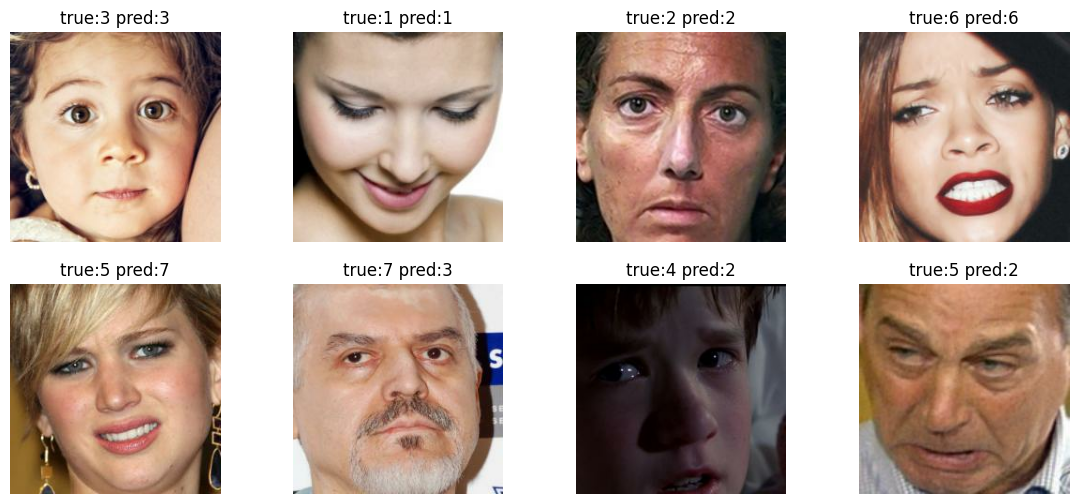

In [28]:
# visualizing some correct and incorrect classification examples
def showPredictionExamples(model, df, numExamples=8):
    # creating a small dataset for visualization
    sampleDf = df.sample(n=min(len(df), 200), random_state=randomSeed)
    ds = makeDataset(sampleDf, batchSize=32, isTraining=False, shuffle=False)
    imgs = []
    trueLabels = []
    predLabels = []
    for batch in ds:
        images, labels = batch
        probs, _ = model.predict(images, verbose=0)
        preds = np.argmax(probs, axis=1)
        trues = np.argmax(labels['classOutput'].numpy(), axis=1)
        for i in range(images.shape[0]):
            imgs.append(images[i].numpy())
            trueLabels.append(trues[i])
            predLabels.append(preds[i])
    # selecting examples
    correctIdx = [i for i in range(len(imgs)) if trueLabels[i]==predLabels[i]]
    wrongIdx = [i for i in range(len(imgs)) if trueLabels[i]!=predLabels[i]]

    plt.figure(figsize=(14,6))
    # showing some correct
    for i, idx in enumerate(correctIdx[:numExamples//2]):
        plt.subplot(2, numExamples//2, i+1)
        plt.imshow(imgs[idx])
        plt.title(f"true:{trueLabels[idx]} pred:{predLabels[idx]}")
        plt.axis('off')
    # showing some incorrect
    for j, idx in enumerate(wrongIdx[:numExamples//2]):
        plt.subplot(2, numExamples//2, numExamples//2 + j + 1)
        plt.imshow(imgs[idx])
        plt.title(f"true:{trueLabels[idx]} pred:{predLabels[idx]}")
        plt.axis('off')
    plt.show()

# visualizing for ResNet50
showPredictionExamples(resnetModel, valDf, numExamples=8)
